In [1]:
import pandas as pd
import numpy as np
import pysam
import matplotlib.pylab as plt
import sys
sys.path.append('/home1/rahmanin/repositories/basenji/basenji')
from dna_io import dna_1hot

### importing data, sequences, ctcf dataframe, bound fraction

In [2]:
bind_sites_filepath = 'sonmezer_dataset_CTCT_binding.sites.filtered.mm10.tsv'
bind_freqs_filepath = 'binding.frequencies.tsv'
ref_genome_filepath = '/project/fudenber_735/genomes/mm10/mm10.fa'

bind_sites = pd.read_table(bind_sites_filepath)
bind_freqs = pd.read_table(bind_freqs_filepath)

site_filter = []
for tfbs in bind_freqs['TFBS_cluster'].unique():
       if len(bind_freqs[bind_freqs['TFBS_cluster'] == tfbs]) == 3:
              site_filter.append(tfbs)
              
bind_sites = bind_sites[bind_sites.rownames.isin(site_filter)]
ref_genome = pysam.FastaFile(ref_genome_filepath)

flank = 300 # considering 300 bp at each side of ctcfs
sequences = []
freqs = []
for idx, row in bind_sites.iterrows():
       chrom, start, end, rownames = row[['chrom', 'start', 'end', 'rownames']]
       seq = (ref_genome.fetch(chrom, int(start - flank), int(end + flank)))
        # Skip sequences containing 'N'
       if 'N' in seq:
            continue
       true_freq = bind_freqs[(bind_freqs.TFBS_cluster == rownames)]['Freqs'].values
       sequences.append(seq)
       freqs.append(true_freq)


freqs = np.array(freqs)

### processing the sequences

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories = 'auto')

input_features = []
for sequence in sequences:
    capitalized_sequence = sequence.upper()
    integer_encoded = integer_encoder.fit_transform(list(capitalized_sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1,1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())
    
input_features = np.stack(input_features)  

### making labels

In [4]:
# we can use eithor or all of the info about accessibility, bound fraction, and nucleosome occupied

In [5]:
freqs_bound = freqs[:,1]
freqs_accessible = freqs[:,0]
freqs_nucleosome = freqs[:,2]

In [33]:
freqs.shape

(8922, 3)

### split the data into train, test

In [6]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(input_features, freqs_bound, test_size=0.25, random_state=35)

### defining the model for linear regression

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

def model_reg(features, learningrate):
    model = Sequential()
    model.add(Input(shape=(features.shape[1], features.shape[2])))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer= Adam(learning_rate = learningrate), loss = 'mean_squared_error')
    return model
    

2024-10-13 20:51:52.869757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 20:51:52.996040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-13 20:51:52.996078: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-13 20:51:54.132679: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

### using bound fraction

In [14]:
train_features, test_features, train_labels, test_labels = train_test_split(input_features, freqs_bound, test_size=0.25, random_state=35)

In [15]:
modelreg = model_reg(train_features, 0.001)
history = modelreg.fit(train_features, train_labels, epochs = 35, batch_size=128, validation_data = (test_features, test_labels),verbose=0)

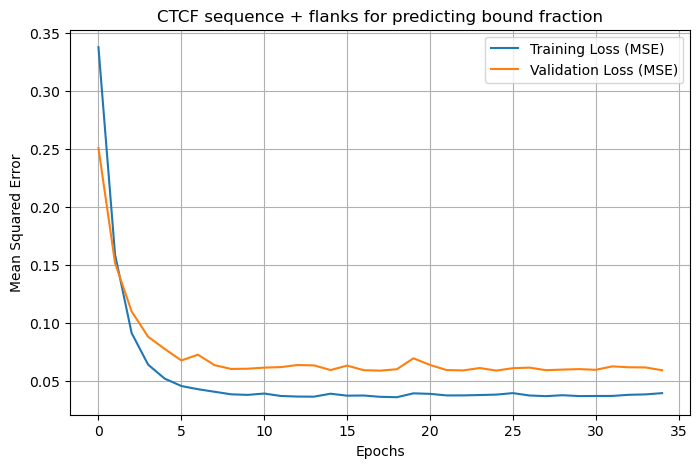

In [16]:
# Extract mean squared error loss from the history object
mse = history.history['loss']
val_mse = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(mse, label='Training Loss (MSE)')
plt.plot(val_mse, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('CTCF sequence + flanks for predicting bound fraction')
plt.legend()
plt.grid(True)
plt.show()

70/70 [==============================] - 0s 461us/step


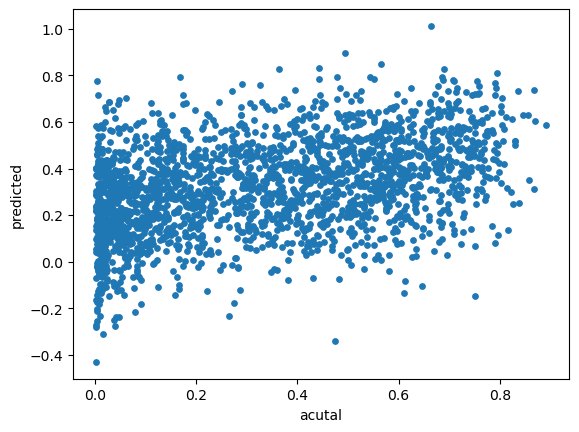

In [24]:
val_predictions = modelreg.predict(test_features)
plt.scatter(test_labels, val_predictions,s=15)
plt.xlabel('acutal')
plt.ylabel('predicted')
plt.show()

### using accessibility

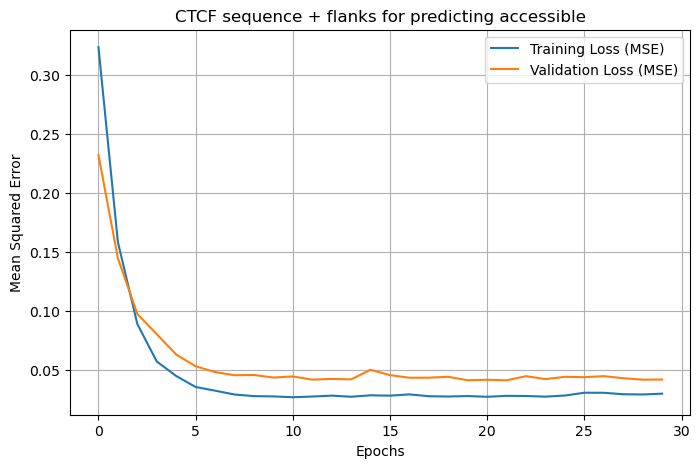

In [30]:
train_features, test_features, train_labels, test_labels = train_test_split(input_features, freqs_accessible, test_size=0.25, random_state=35)
modelreg = model_reg(train_features, 0.001)
history = modelreg.fit(train_features, train_labels, epochs = 30, batch_size=128, validation_data = (test_features, test_labels),verbose=0)
# Extract mean squared error loss from the history object
mse = history.history['loss']
val_mse = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(mse, label='Training Loss (MSE)')
plt.plot(val_mse, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('CTCF sequence + flanks for predicting accessible')
plt.legend()
plt.grid(True)
plt.show()

70/70 [==============================] - 0s 458us/step


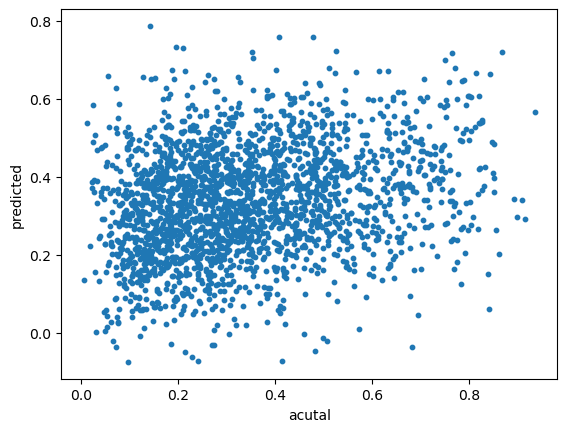

In [31]:
val_predictions = modelreg.predict(test_features)
plt.scatter(test_labels, val_predictions,s=10)
plt.xlabel('acutal')
plt.ylabel('predicted')
plt.show()

### using nucleosome

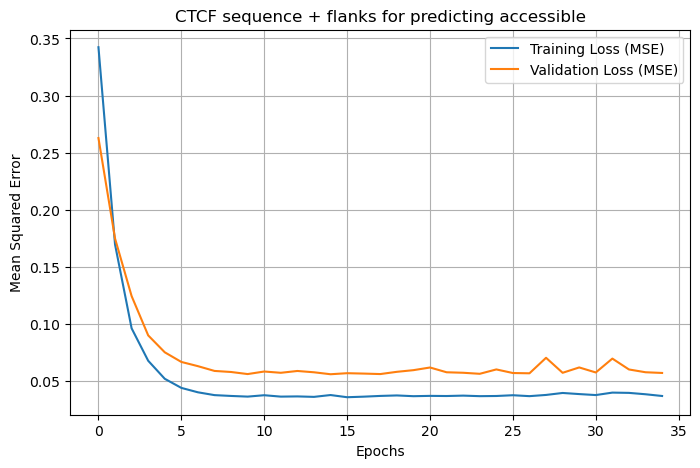

In [28]:
train_features, test_features, train_labels, test_labels = train_test_split(input_features, freqs_nucleosome, test_size=0.25, random_state=35)
modelreg = model_reg(train_features, 0.001)
history = modelreg.fit(train_features, train_labels, epochs = 35, batch_size=128, validation_data = (test_features, test_labels),verbose=0)
# Extract mean squared error loss from the history object
mse = history.history['loss']
val_mse = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(mse, label='Training Loss (MSE)')
plt.plot(val_mse, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('CTCF sequence + flanks for predicting accessible')
plt.legend()
plt.grid(True)
plt.show()

70/70 [==============================] - 0s 453us/step


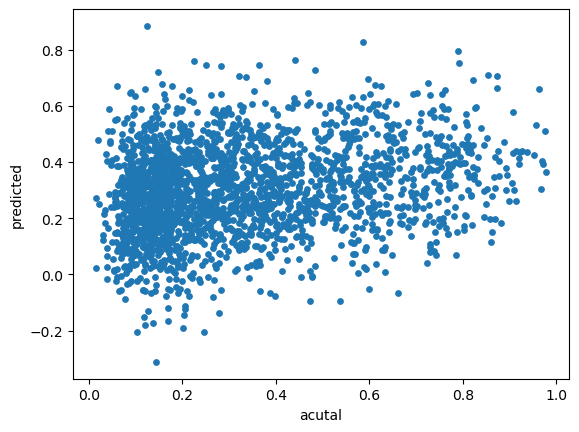

In [29]:
val_predictions = modelreg.predict(test_features)
plt.scatter(test_labels, val_predictions,s=15)
plt.xlabel('acutal')
plt.ylabel('predicted')
plt.show()

### using all there labels:

In [49]:
def model_reg_3(features, learningrate):
    model = Sequential()
    model.add(Input(shape=(features.shape[1], features.shape[2])))
    model.add(Flatten())
    model.add(Dense(3))
    model.compile(optimizer= Adam(learning_rate = learningrate), loss = 'mean_squared_error')
    return model

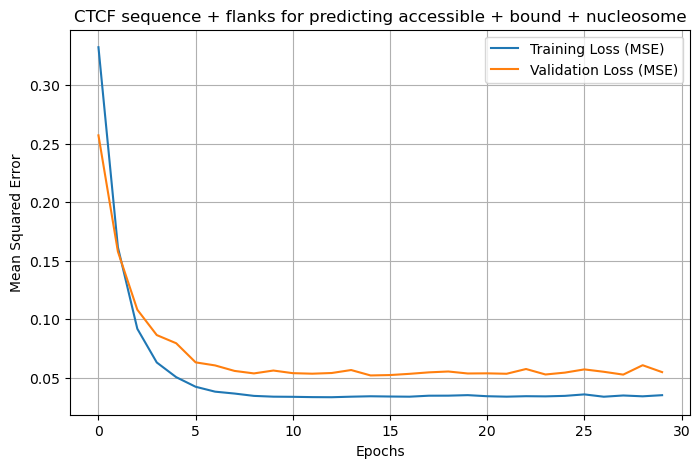

In [50]:
train_features, test_features, train_labels, test_labels = train_test_split(input_features, freqs, test_size=0.25, random_state=35)
modelreg = model_reg_3(train_features, 0.001)
history = modelreg.fit(train_features, train_labels, epochs = 30, batch_size=128, validation_data = (test_features, test_labels),verbose=0)
# Extract mean squared error loss from the history object
mse = history.history['loss']
val_mse = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(mse, label='Training Loss (MSE)')
plt.plot(val_mse, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('CTCF sequence + flanks for predicting accessible + bound + nucleosome')
plt.legend()
plt.grid(True)
plt.show()

70/70 [==============================] - 0s 474us/step


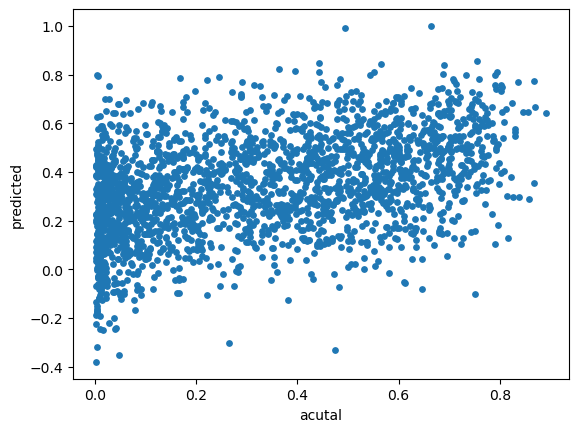

In [51]:
val_predictions = modelreg.predict(test_features)
plt.scatter(test_labels[:,1], val_predictions[:,1],s=15)
plt.xlabel('acutal')
plt.ylabel('predicted')
plt.show()

70/70 [==============================] - 0s 470us/step


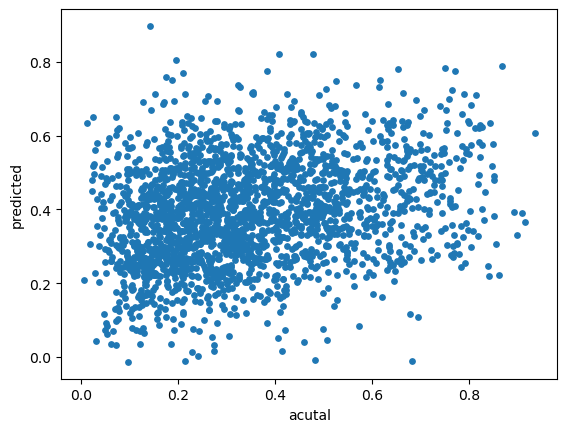

In [52]:
val_predictions = modelreg.predict(test_features)
plt.scatter(test_labels[:,0], val_predictions[:,0],s=15)
plt.xlabel('acutal')
plt.ylabel('predicted')
plt.show()

70/70 [==============================] - 0s 481us/step


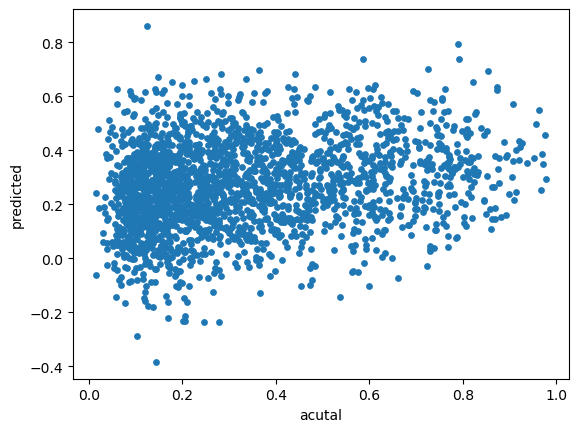

In [53]:
val_predictions = modelreg.predict(test_features)
plt.scatter(test_labels[:,2], val_predictions[:,2],s=15)
plt.xlabel('acutal')
plt.ylabel('predicted')
plt.show()